# **Classificação de Gênero de Música**

Author: Arthur Felipe Thamay

Anteriormente, trabalhamos com o agrupamento das músicas com base em sua letra. Agora, utilizaremos caracteristicas extraídas das músicas para classificar seu gênero, tentando obter melhor resultado utilizando técnicas de Deep Learning. 

**Descrição dos dados:**

* **SName**: Nome da música
* **Artist**: Artista autor da música
* **Genre**: Gênero da música. Variável alvo
* **uri**: ID da música
* **danceability**: De 0 a 1 o quanto a música é dançável, baseado no tempo, batida, ritmo, estabilidade, etc.
* **energy**: De 0 a 1 o quanto a música é energética. Músicas energéticas tendem a ser mais altas, barulhentas, e rápidas.
* **key**: Nota ou tom predominante.
* **loudness**: O quanto a música é barulhenta, em decibéis.
* **mode**: Tom maior ou menor. Músicas em tom maior tendem a ser consideradas mais alegres, enquanto músicas em tom menor são consideradas tristes.
* **speechiness**: De 0 a 1, quanto de palavras faladas há na música. Valores mais próximos de 0 indicam maior chance de ser uma música, enquanto valores mais próximos de 1 indicam mais chance de ser um discurso.
* **acousticness**: Probabilidade da música ser gravada em acústico.
instrumentalness: De 0 a 1, o quanto a música é instrumental. Músicas que contém canto são mais próximas de 0, enquanto músicas que não contém são mais próximas de 1.
* **liveness**: De 0 a 1, a probabilidade da música ter sido gravada ao vivo. Detecta principalmente a presença de platéia.
* **valence**: De 0 a 1, descreve a positividade da música.
* **tempo**: O tempo da música em batidas por minuto (BPM).
* **duration_ms**: Duração da música em milissegundos
* **time_signature**: Batidas num período de tempo.

**As atividades esperadas para essa etapa são descritas a seguir:**

1. Realize uma análise exploratória nos dados, identificando e explorando:
* Checar distribuição das variáveis, realizando normalização caso julgue 2. necessário;
* Correlações entre as variáveis;
* Checar distribuição das classes, realizando balanceamento caso julgue necessário.
2. Tune, usando validação cruzada e outras medidas para controlar o overfitting caso necessário:
* Dois modelos de classificação vistos anteriormente (por exemplo, Regressão Logística)
* Dois modelos Multilayer Perceptron (MLP), variando o número de camadas, neurônios, e funções de ativação.
3. Identifique os valores de Precision, Recall, Acurácia e F1-Score para os modelos utilizados. 
4. Identifique o melhor modelo e treine-o novamente utilizando os melhores valores de parâmetros encontrados. Use esse modelo para prever os dados de teste. Reporte os resultados encontrados, utilizando as métricas utilizadas anteriormente, além de uma matriz de confusão.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification, make_regression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification, make_regression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.get_cmap('Blues')):
    # Função importada dos exemplos do SKLearn
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
from keras import backend as K

def plot_random_batch(batch, y_true, y_pred=None, batch_size=30, n_cols=10, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    random_idx = np.random.choice(batch.shape[0], size=batch_size)
    x_batch = batch[random_idx].squeeze()
    y_batch = y_true[random_idx]
    
    y_pred = y_batch if y_pred is None else y_pred[random_idx]
    n_rows = x_batch.shape[0] // n_cols + 1
    is_gray = (batch.shape[-1] == 1 or batch.ndim == 3)
    for img, true, pred, sub in zip(x_batch, y_batch, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)
        
        plt.title("T:{} P:{}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()
    
def make_cubic(n_samples, x_min, x_max, a=1, b=0, c=0, d=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**3 + b*x**2 + c*x + d + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)

def make_exp(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = np.exp(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_log10(n_samples, x_min, x_max, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.logspace(np.log10(x_min), np.log10(x_max), n_samples)
    y = np.log10(x) + 2*noise*np.random.random(n_samples) - noise
    return x.reshape(-1,1), y.reshape(-1,1)

def make_square(n_samples, x_min, x_max, a=1, b=0, c=0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(x_min, x_max, n_samples)
    y = a*x**2 + b*x + c + (2*noise*np.random.random(n_samples) - noise)
    return x.reshape(-1,1), y.reshape(-1,1)
    
def make_spiral(n_samples, n_class=2, radius=1, laps=1.0, noise=0.0, random_state=None):
    np.random.seed(random_state)
    x = np.zeros((n_samples * n_class, 2))
    y = np.zeros((n_samples * n_class))
    
    pi_2 = 2 * np.math.pi
    points = np.linspace(0, 1, n_samples)
    r = points * radius
    t = points * pi_2 * laps
    for label, delta_t in zip(range(n_class), np.arange(0, pi_2, pi_2/n_class)):
        random_noise = (2 * np.random.rand(n_samples) - 1) * noise
        index = np.arange(label*n_samples, (label+1)*n_samples)
        x[index] = np.c_[r * np.sin(t + delta_t) + random_noise,
                         r * np.cos(t + delta_t) + random_noise]
        y[index] = label
    return x, y.reshape(-1, 1)
  
def __softmax(x):
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def __compute_meshgrid(x, y):
    x_min, x_max, y_min, y_max = x[:, 0].min(), x[:, 0].max(), x[:, 1].min(), x[:, 1].max()
    x1, x2 = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    x_mesh = np.array([x1.ravel(), x2.ravel()]).T
    return x1, x2, x_mesh

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def plot_hist_and_predictions(history, x, y, model, s=15, cmap=plt.cm.viridis):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    ax = plt.subplot(1, 2, 2)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)

    plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
    x1, x2, x_mesh = __compute_meshgrid(x, y)
    y_mesh = model.predict_classes(x_mesh)
    plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=s, cmap=cmap)
    plt.contourf(x1, x2, y_mesh.reshape(x1.shape), cmap=cmap, alpha=0.5)
    
def plot_hist_and_line(history, x, y, model):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.subplot(1, 2, 2)
    x_test = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_test)
    plt.scatter(x, y)
    plt.plot(x_test, y_pred, color='green')
    plt.xlabel('x')
    plt.ylabel('y')

def plot_hist_and_predictions_recall(history, x, y, model):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['recall'])
    plt.xlabel('epochs')
    plt.ylabel('recall')

    plt.subplot(1, 2, 2)
    x_test = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_test)
    plt.scatter(x, y)
    plt.plot(x_test, y_pred, color='green')
    plt.xlabel('x')
    plt.ylabel('y')


## **Carregando os dados**

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1zBIkLjUft3HgkXGOFgWAl68LiWTzoep9')
df.head()

,SName,Artist,Genre,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Esperança,Aliados,Rock,spotify:track:63hfFSvMiAmIhet3runSer,0.540000,0.935,1.0,-5.132000,0.0,0.0569,0.002869,0.000000,0.2910,0.457999,120.052000,185520,4
1,Te Encontro Por Aí,Aliados,Rock,spotify:track:7jMXh3GaRS6WBvSN9tGklB,0.462999,0.764,8.0,-4.123999,1.0,0.0791,0.078100,0.000000,0.1130,0.450000,169.619000,184747,4
2,Pra Ser Feliz,Aliados,Rock,spotify:track:1K7IAeOK4N7SiJwx1GrQkk,0.632000,0.582,10.0,-5.941000,0.0,0.0298,0.257000,0.000000,0.1190,0.711000,116.902999,157533,4
3,Águas Passadas,Aliados,Rock,spotify:track:5IUct7lJG41x8YA0ixTo1E,0.598000,0.545,0.0,-7.996000,0.0,0.0251,0.550000,0.000172,0.1110,0.414000,104.026000,173640,4
4,No Seu Coração,Aliados,Rock,spotify:track:59B1xAWXsS9dNLIrsZNPMg,0.617000,0.664,7.0,-6.489000,0.0,0.0279,0.058300,0.000000,0.0795,0.770999,80.068000,159120,4


In [ ]:
df.sample(10)

,SName,Artist,Genre,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
13702,Interrogações,Lucas Lucco,Sertanejo,spotify:track:0weWitdeHvZJWRYtlNM2Go,0.558999,0.665,9.0,-8.332000,1.0,0.036200,0.542999,0.000027,0.412000,0.557000,159.952000,179253,3
8278,Me Leva Pra Casa,Péricles,Samba,spotify:track:2rFaizZQlC1mUy9orrnEK2,0.544000,0.742,8.0,-6.101000,1.0,0.044300,0.662999,0.000000,0.424000,0.728000,85.786000,220453,4
16140,A Viola E O Violeiro,Tião Carreiro e Pardinho,Sertanejo,spotify:track:6JC1lEFOLbn4wqt29CY1Tq,0.531000,0.633,3.0,-3.791000,1.0,0.129000,0.665999,0.000000,0.071000,0.667999,172.278000,152213,3
7395,Jorge da Capadocia,Jorge Ben Jor,Samba,spotify:track:06YxPcR6dTaSC5ee3uxWdI,0.462999,0.820,0.0,-6.905000,1.0,0.049900,0.532000,0.000002,0.117000,0.689000,110.148000,231080,4
10644,Deste Lado Ou do Outro,Cristiano Araújo,Sertanejo,spotify:track:2dp7y7SiSEYhRlTE5Ft3Zp,0.611000,0.714,7.0,-3.985000,1.0,0.032099,0.222000,0.000000,0.943000,0.536000,120.259000,193453,3
14898,Funeral de Um Lavrador,Renato Teixeira,Sertanejo,spotify:track:3iW6kGzVqKyPgvurHT7KGw,0.744000,0.445,2.0,-10.908000,0.0,0.034900,0.885999,0.000094,0.096100,0.716000,120.025000,201933,4
13524,Maior Amor Do Mundo,Leonardo,Sertanejo,spotify:track:1HE7K11Oezkq39DYcYV3vf,0.282000,0.583,9.0,-7.819000,1.0,0.039400,0.065000,0.000000,0.193999,0.174000,147.434000,274933,4
8121,Silêncio,Nosso Sentimento,Samba,spotify:track:6Mj55QSHEG6TezTyKe4rY4,0.514000,0.775,2.0,-4.971999,1.0,0.034200,0.617000,0.000000,0.679000,0.469000,137.977999,213587,4
10623,Efeitos (part. Jorge e Mateus),Cristiano Araújo,Sertanejo,spotify:track:2vfEXp8mdx4Re0PzpxZX4o,0.644000,0.546,2.0,-13.485000,0.0,0.032300,0.086000,0.925000,0.288000,0.853000,139.993000,215066,4
10838,"Te Cuida, Coração",Daniel,Sertanejo,spotify:track:0uk1O12Jr6SzJALFksSJto,0.736000,0.709,7.0,-6.974000,1.0,0.030500,0.495000,0.000000,0.381000,0.473000,128.183000,246600,4


In [ ]:
df.shape

(17280, 17)

In [ ]:
df.dtypes

SName                object
Artist               object
Genre                object
uri                  object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

In [ ]:
df['mode'].unique()

array([0., 1.])

### Sumário dos Dados

Inicialmente vamos identificar nossas variáveis, por meio da biblioteca do Pandas, na qual gera estatísticas descritivas, resumindo a tendência central, a dispersão e a forma da distribuição de um conjunto de dados. 

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,17280.0,0.590279,0.132760,0.000000,0.507000,0.6030,0.686000,0.964
energy,17280.0,0.675720,0.195802,0.000020,0.541000,0.6950,0.836000,0.999
key,17280.0,5.353819,3.531892,0.000000,2.000000,5.0000,9.000000,11.000
loudness,17280.0,-7.438066,3.241281,-33.951000,-9.232999,-6.8775,-5.094750,0.120
mode,17280.0,0.773495,0.418581,0.000000,1.000000,1.0000,1.000000,1.000
speechiness,17280.0,0.067408,0.065493,0.000000,0.033300,0.0443,0.072200,0.948
acousticness,17280.0,0.406279,0.270014,0.000002,0.166000,0.4070,0.631000,0.996
instrumentalness,17280.0,0.013594,0.087590,0.000000,0.000000,0.0000,0.000012,0.960
liveness,17280.0,0.338270,0.285395,0.015000,0.114000,0.2210,0.477000,1.000
valence,17280.0,0.649321,0.222121,0.000000,0.490000,0.6750,0.838000,0.996


## **Data Analysis**

Vamos analisar a correlação.

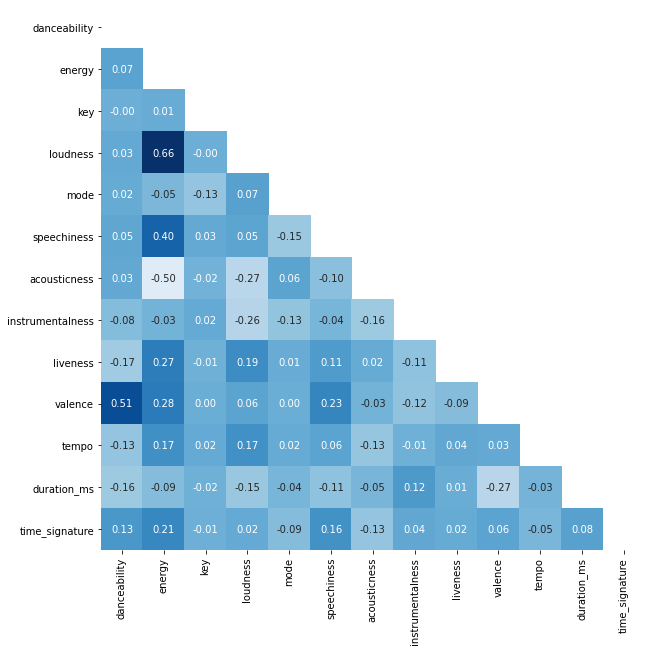

In [ ]:
corr = df.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 10)
sns.heatmap(corr, ax=ax, annot=True, mask=mask, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Blues, center=0)

### Análise exploratória

Vamos verificar o balanceamento entre as variaveis gênero musical.

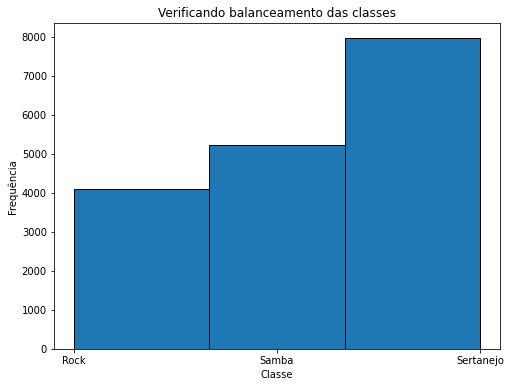

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Verificando balanceamento das classes')
plt.hist(df['Genre'], bins=3, edgecolor='black', linewidth=1)
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

Tomando como base em que, a váriável "Genre" contem "Rock", "Samba" e "Sertanejo". Dessa forma, realizamos um procedimento chamado UnderSampling, onde reduzimos o número de amostras de uma classe, para que o dataset fique mais balanceado.

In [ ]:
n_samples = int(len(df[df['Genre'] == 'Rock']))
print(n_samples)
balanced_df = pd.concat([df[df['Genre'] == 'Rock'],
                        df[df['Genre'] == 'Samba'].sample(n_samples),   
                        df[df['Genre'] == 'Sertanejo'].sample(n_samples)],
                        ignore_index=True).reset_index(drop=True)

4084


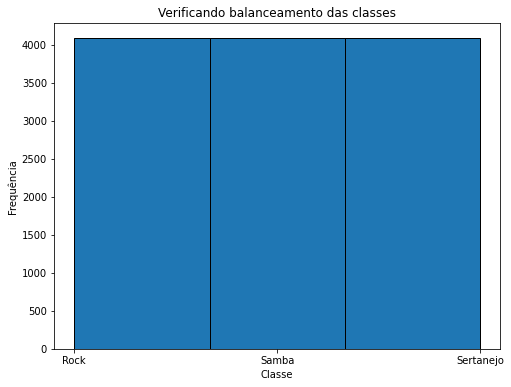

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Verificando balanceamento das classes')
plt.hist(balanced_df['Genre'], bins=3, edgecolor='black', linewidth=1)
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.show()

In [ ]:
balanced_df.head()

,SName,Artist,Genre,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Esperança,Aliados,Rock,spotify:track:63hfFSvMiAmIhet3runSer,0.540000,0.935,1.0,-5.132000,0.0,0.0569,0.002869,0.000000,0.2910,0.457999,120.052000,185520,4
1,Te Encontro Por Aí,Aliados,Rock,spotify:track:7jMXh3GaRS6WBvSN9tGklB,0.462999,0.764,8.0,-4.123999,1.0,0.0791,0.078100,0.000000,0.1130,0.450000,169.619000,184747,4
2,Pra Ser Feliz,Aliados,Rock,spotify:track:1K7IAeOK4N7SiJwx1GrQkk,0.632000,0.582,10.0,-5.941000,0.0,0.0298,0.257000,0.000000,0.1190,0.711000,116.902999,157533,4
3,Águas Passadas,Aliados,Rock,spotify:track:5IUct7lJG41x8YA0ixTo1E,0.598000,0.545,0.0,-7.996000,0.0,0.0251,0.550000,0.000172,0.1110,0.414000,104.026000,173640,4
4,No Seu Coração,Aliados,Rock,spotify:track:59B1xAWXsS9dNLIrsZNPMg,0.617000,0.664,7.0,-6.489000,0.0,0.0279,0.058300,0.000000,0.0795,0.770999,80.068000,159120,4


## **Manipulação dos dados**

Inicialmente, transformamos as colunas textuais em colunas numéricas.

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['SName'].tolist())
balanced_df['SName'] = labels

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['Artist'].tolist())
balanced_df['Artist'] = labels

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['Genre'].tolist())
balanced_df['Genre'] = labels

In [ ]:
status_encoder = LabelEncoder()
labels = status_encoder.fit_transform(balanced_df['uri'].tolist())
balanced_df['uri'] = labels

In [ ]:
balanced_df.head()

,SName,Artist,Genre,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,3578,4,0,9224,0.540000,0.935,1.0,-5.132000,0.0,0.0569,0.002869,0.000000,0.2910,0.457999,120.052000,185520,4
1,10262,4,0,11530,0.462999,0.764,8.0,-4.123999,1.0,0.0791,0.078100,0.000000,0.1130,0.450000,169.619000,184747,4
2,8366,4,0,1998,0.632000,0.582,10.0,-5.941000,0.0,0.0298,0.257000,0.000000,0.1190,0.711000,116.902999,157533,4
3,11650,4,0,8085,0.598000,0.545,0.0,-7.996000,0.0,0.0251,0.550000,0.000172,0.1110,0.414000,104.026000,173640,4
4,6541,4,0,7881,0.617000,0.664,7.0,-6.489000,0.0,0.0279,0.058300,0.000000,0.0795,0.770999,80.068000,159120,4


Vamos verificar os tipos de nossas variáveis.

In [ ]:
balanced_df.dtypes

SName                 int64
Artist                int64
Genre                 int64
uri                   int64
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

Tendo em vista que o objetivo da normalização é alterar os valores das colunas numéricas no dataframe para uma escala comum, sem distorcer as diferenças nos intervalos de valores, normalizamos nosso conjunto de dados pelo fato de que alguns dps nossos parâmetros terem intervalos muito diferentes.

In [ ]:
scaler = MinMaxScaler()
transformed = scaler.fit_transform(balanced_df.drop(['Genre'], axis=1))
transformed_df = pd.DataFrame(transformed)
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.303503,0.019231,0.773112,0.560166,0.935935,0.090909,0.845851,0.0,0.060403,0.002881,0.00000,0.280773,0.461693,0.515313,0.148506,0.8
1,0.870472,0.019231,0.966390,0.480289,0.764760,0.727273,0.875437,1.0,0.083970,0.078491,0.00000,0.099695,0.453629,0.728075,0.147830,0.8
2,0.709645,0.019231,0.167463,0.655602,0.582574,0.909091,0.822107,0.0,0.031635,0.258290,0.00000,0.105799,0.716734,0.501796,0.124019,0.8
3,0.988209,0.019231,0.677646,0.620332,0.545536,0.000000,0.761792,0.0,0.026645,0.552763,0.00018,0.097660,0.417339,0.446523,0.138112,0.8
4,0.554839,0.019231,0.660548,0.640041,0.664658,0.636364,0.806023,0.0,0.029618,0.058591,0.00000,0.065615,0.777217,0.343685,0.125407,0.8


## **Treinando os modelos**

Na etapa de classificação vamos separar os dados entre treino, teste e validação. Entretanto, a validação será feita utilizando Cross Validation. 

Além disso, aplicaremos uma última transformação nos dados: criaremos um novo vetor para conter nossa variável alvo (Genre), teremos Rock, Samba e Sertanejo.


In [ ]:
y = pd.Series([0 if sm == 0 else 1 if sm == 1 else 2 for sm in balanced_df['Genre']])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(transformed_df, y)

In [ ]:
folds = 10
kfold = StratifiedKFold(folds)

Para validação cruzada o sklearn dispoe de basicamente 3 funções:

*   cross_val_score: Avalia uma pontuação por validação cruzada
*   cross_validate: Executa a validação cruzada em várias métricas e também para retornar pontuações de treino, tempos de ajuste e tempos de pontuação
*   cross_val_predict: Obtem previsões de cada divisão da validação cruzada para fins de diagnóstico.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

In [ ]:
def get_model_fit(metrics):
    model = metrics['estimator'][0]
    metrics.pop('estimator')
    return model

In [ ]:
def print_metrics_models(metrics):
    for key in metrics.keys():
        print(key, " = ", metrics.get(key, 0).mean())

In [ ]:
def vis_metrics_model(metrics):
    metrics_vis = metrics
    
    for key in ['fit_time', 'score_time']:
        metrics_vis.pop(key) 
    
    x = [key for key in metrics_vis.keys()]
    y = [metrics_vis.get(key, 0).mean() for key in metrics_vis.keys()]
    
    sns.set(rc={'figure.figsize':(12,5)})
    ax = sns.barplot(x=x, y=y, palette='rocket')
    ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [ ]:
scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']

accuracy = 'accuracy'
precision = 'precision'
f1 = 'f1'
cv = 5

## **Modelos de classificação vistos anteriormente**

### Regressão Logística

Definimos no array `logreg_C` os possíveis valores para o parâmetro `C` da regressão logística. Esse parâmetro se refere a força da regularização.
Utilizamos o KFold feito manualmente e posteriormente declaramos algumas variáveis para manter os valores atuais da melhor predição.
A ideia é testar os diferentes valores de C e re-treinar o modelo com o C que obteve menor erro de validação.

In [ ]:
logreg_C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_c = logreg_C[0]
best_score = 0
best_accuracy = 0
avg_scores = []

for c in logreg_C:
    score = 0
    accuracy = 0
    for train_index, test_index in kfold.split(x_train, y_train):
        x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model = LogisticRegression(C=c, random_state=31, max_iter=2000)
        model.fit(x_train_fold, y_train_fold)
        pred = model.predict(x_test_fold)

        score += f1_score(y_test_fold, pred, average='micro')
        accuracy += accuracy_score(y_test_fold, pred)


    score = score / folds # média
    avg_scores.append(score)
    accuracy = accuracy / folds
    if (score > best_score):
        best_score = score
        best_accuracy = accuracy
        best_c = c

print(f'Melhor C: {best_c}. Resultou no F1 {best_score} e Acurácia {best_accuracy} durante o {folds}-fold')

Melhor C: 1. Resultou no F1 0.7284810381654777 e Acurácia 0.7284810381654777 durante o 10-fold


Re-treinamos o modelo com todos os dados e avaliamos no conjunto de testes

In [ ]:
model = LogisticRegression(C = best_c, max_iter=10000)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [ ]:
f1 = f1_score(y_test, pred, average='macro')
accuracy = accuracy_score(y_test, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.7061516790480348 e Acurácia 0.7061704211557297


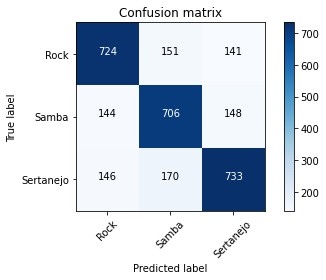

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, ['Rock', 'Samba', 'Sertanejo'])

Para a Matriz de confusão, a diagonal principal corresponde aos verdadeiros positivos, isto é, os casos em que os ritmos musicais foram previstos corretamente.
* Para o ritmo de Rock, 738 músicas foram preditas corretamente como Rock, 146 configuram um FP por serem classificados como samba e 158 músicas FP com predição em Rock, mas classificação real em Sertanejo
* Para as músicas predispostas como ritmo de samba, 737 corraboraram com a previsão, 189 foram FP (144 eram sertanejo e 135 eram Rock).
* Para as músicas inicialmente ditas Sertanejo, 724 estavam de acordo com a primeira orientação, mas 125 foram posteriormente classificadas em rock e 155 em Samba, configurando FP.

### Árvore de Decisão

Repetindo o mesmo procedimento para Árvore de decisão, mas agora utilizando GridSearch para simplificar o processo de cross validation:

In [ ]:
dtree = DecisionTreeClassifier()
dtree_params = { 'max_depth': [5, 10, 15], 'max_leaf_nodes': [10, 20, 30] }
grid = GridSearchCV(dtree, dtree_params, scoring='f1_macro', cv=folds)
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 15],
                         '

In [ ]:
print(f'Melhor depth: {grid.best_params_["max_depth"]}. Melhor num de folhas: {grid.best_params_["max_leaf_nodes"]}')
print(f'Resultou no F1 {grid.best_score_} durante o {folds}-fold')

Melhor depth: 15. Melhor num de folhas: 30
Resultou no F1 0.7406353647969508 durante o 10-fold


In [ ]:
pred = grid.predict(x_test)
f1 = f1_score(y_test, pred, average='macro')
accuracy = accuracy_score(y_test, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.720918765979223 e Acurácia 0.7215148547175971


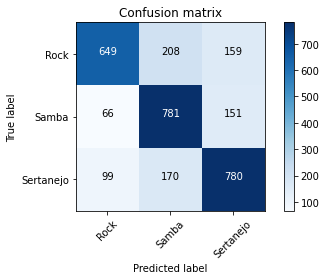

In [ ]:
conf = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf, ['Rock', 'Samba', 'Sertanejo'])

Agora, ao invés de termos nossas variáveis guardando o melhor valor de cada parâmetro, iremos recuperar esses valores do grid search e visualizar:

In [ ]:
grid_cv = pd.DataFrame.from_dict(grid.cv_results_)
grid_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051602,0.003394,0.002242,0.000268,5,10,"{'max_depth': 5, 'max_leaf_nodes': 10}",0.698957,0.711441,0.707876,0.721531,0.714049,0.696448,0.692765,0.711136,0.719432,0.715745,0.708938,0.009331,7
1,0.053485,0.001085,0.002195,0.000064,5,20,"{'max_depth': 5, 'max_leaf_nodes': 20}",0.713047,0.714880,0.718307,0.732171,0.723622,0.714057,0.723433,0.736362,0.735958,0.717357,0.722920,0.008544,5
2,0.055856,0.001411,0.002154,0.000066,5,30,"{'max_depth': 5, 'max_leaf_nodes': 30}",0.713047,0.713801,0.720474,0.728993,0.720425,0.714134,0.722324,0.737507,0.735958,0.717357,0.722402,0.008475,6
3,0.053099,0.001378,0.002228,0.000360,10,10,"{'max_depth': 10, 'max_leaf_nodes': 10}",0.698957,0.711441,0.707876,0.721531,0.714049,0.696448,0.692765,0.711136,0.719432,0.715745,0.708938,0.009331,7
4,0.065631,0.001052,0.002236,0.000068,10,20,"{'max_depth': 10, 'max_leaf_nodes': 20}",0.725787,0.726633,0.707993,0.743415,0.743330,0.713025,0.724758,0.746386,0.747094,0.729734,0.730816,0.013194,3


## **Modelos Multilayer Perceptron (MLP)**

### 3 Clusters

(300, 2) (300, 1)


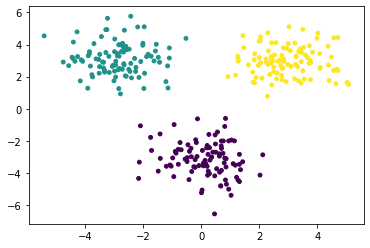

In [ ]:
x_test, y_test = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y_test = y_test.reshape(-1, 1)
print(x_test.shape, y_test.shape)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test.flatten(), s=15)

(300, 2) (300, 1)


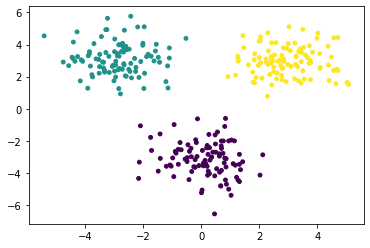

In [ ]:
x_train, y_train = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y_train = y_train.reshape(-1, 1)
print(x_train.shape, y_train.shape)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train.flatten(), s=15)

Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 1.2428 - accuracy: 0.1600 - f1_m: 1.6137 - precision_m: 2.0155 - recall_m: 1.3595
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2244 - accuracy: 0.2133 - f1_m: 1.6470 - precision_m: 2.1167 - recall_m: 1.3755
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2072 - accuracy: 0.2300 - f1_m: 1.6791 - precision_m: 2.6086 - recall_m: 1.3560
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 1.1933 - accuracy: 0.2467 - f1_m: 1.6938 - precision_m: 2.2677 - recall_m: 1.3761
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 1.1813 - accuracy: 0.2667 - f1_m: 1.7251 - precision_m: 2.4131 - recall_m: 1.3692
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 1.1708 - accuracy: 0.2767 - f1_m: 1.7697 - precision_m: 2.5447 - recall_m: 1.3827
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - los

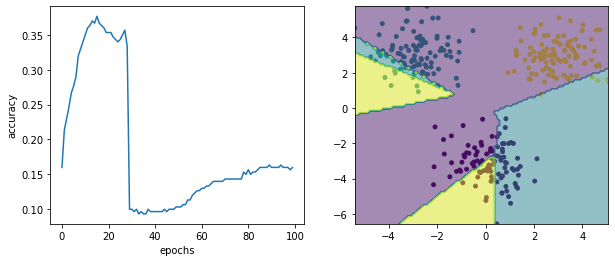

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=3, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test, y_test, batch_size=30, epochs=100)

plot_hist_and_predictions(hist.history, x_test, y_test, model)

Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3066 - accuracy: 0.0367 - f1_m: 0.7575 - precision_m: 0.7566 - recall_m: 0.7805
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2792 - accuracy: 0.0533 - f1_m: 0.8171 - precision_m: 0.8273 - recall_m: 0.8285
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2555 - accuracy: 0.0300 - f1_m: 0.9069 - precision_m: 0.9243 - recall_m: 0.8975
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2335 - accuracy: 0.0500 - f1_m: 0.9992 - precision_m: 1.0581 - recall_m: 0.9890
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2149 - accuracy: 0.0600 - f1_m: 1.0196 - precision_m: 1.0783 - recall_m: 0.9889
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 1.1989 - accuracy: 0.0767 - f1_m: 1.0761 - precision_m: 1.2061 - recall_m: 0.9900
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - los

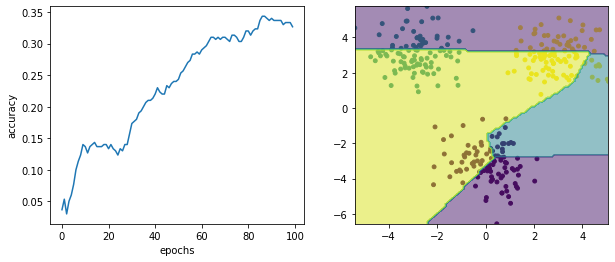

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=3, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

hist = model.fit(x_train, y_train, batch_size=30, epochs=100)

plot_hist_and_predictions(hist.history, x_train, y_train, model)

* A acurácia se refere à proximidade entre o valor obtido de treino e o valor de teste. Como resultado, obteve-se um valor de para teste de 0.09 e 0.31 para o valor de treino. 
* A precisão é o grau de variação de resultados de uma amostra, tendo como base o desvio-padrão. Obtivemos um resultado de 0.50 de treino e 0.72 de teste.
* Recall é a frequência em que o seu classificador encontra os exemplos de uma classe, ou seja, o numero de verdadeiros positivos e verdadeiros negativos. Os resultados de recall froma de 0.53 para teste e 0.88 para treino.
* F1-Score faz uma combinação entre precisão e recall, em relação ao quanto o classificador atinge resultados verdadeiros e o quanto a variabilidade dos ddos é pequena, tornando o modelo mais confiável. Como resultados, obtivemos os valores de 0.51 para teste e de 0.79 para treino.
* Em geral, os valores de precisão, recall e F1-Score foram os mais altos e mais próximos entre treino e teste.

### 4 Clusters

(400, 2) (400, 1)


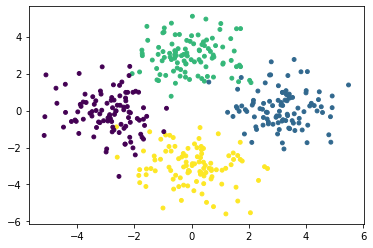

In [ ]:
x_test, y_test = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y_test = y_test.reshape(-1, 1)
print(x_test.shape, y_test.shape)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test.flatten(), s=15)

(400, 2) (400, 1)


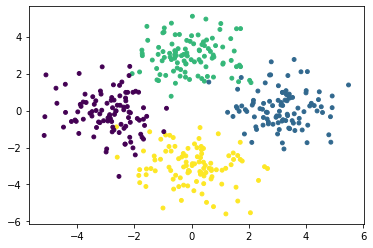

In [ ]:
x_treino, y_treino = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y_treino = y_treino.reshape(-1, 1)
print(x_treino.shape, y_treino.shape)

plt.scatter(x_treino[:, 0], x_treino[:, 1], c=y_treino.flatten(), s=15)

Epoch 1/100
13/13 [==============================] - 0s 1ms/step - loss: 1.3333 - accuracy: 0.2525 - f1_m: 2.4147 - precision_m: 4.7298 - recall_m: 1.6450
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2538 - accuracy: 0.2625 - f1_m: 2.5625 - precision_m: 5.3824 - recall_m: 1.7168
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1965 - accuracy: 0.2825 - f1_m: 2.5069 - precision_m: 5.7130 - recall_m: 1.6713
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1576 - accuracy: 0.3450 - f1_m: 2.5663 - precision_m: 6.3120 - recall_m: 1.6824
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1292 - accuracy: 0.4325 - f1_m: 2.4664 - precision_m: 5.1744 - recall_m: 1.6528
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1051 - accuracy: 0.4775 - f1_m: 2.4880 - precision_m: 5.5326 - recall_m: 1.6744
Epoch 7/100
13/13 [==============================] - 0s 1ms/step - los

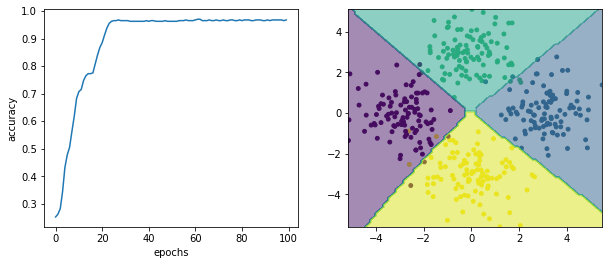

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=20, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=4, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test, y_test, batch_size=32, epochs=100)

plot_hist_and_predictions(hist.history, x_test, y_test, model)

Epoch 1/100
13/13 [==============================] - 0s 1ms/step - loss: 1.5311 - accuracy: 0.2500 - f1_m: 2.7072 - precision_m: 17692318.0000 - recall_m: 1.5636
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 1.3697 - accuracy: 0.2500 - f1_m: 2.8228 - precision_m: 16.3295 - recall_m: 1.5935
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2475 - accuracy: 0.2500 - f1_m: 2.6835 - precision_m: 12.0012 - recall_m: 1.5804
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1450 - accuracy: 0.2600 - f1_m: 2.6430 - precision_m: 7.1304 - recall_m: 1.6489
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 1.0493 - accuracy: 0.4650 - f1_m: 2.1686 - precision_m: 5.0202 - recall_m: 1.4110
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 0.9534 - accuracy: 0.6500 - f1_m: 1.9243 - precision_m: 4.2839 - recall_m: 1.2911
Epoch 7/100
13/13 [==============================] - 0s 1ms/s

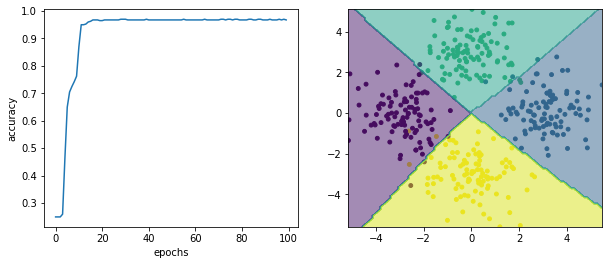

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=20, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=4, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_treino, y_treino, batch_size=32, epochs=100)

plot_hist_and_predictions(hist.history, x_treino, y_treino, model)

* A acurácia obteve-se um valor de para teste de 0.90 e 0.96 para o valor de treino. 
* A precisão obteve um resultado de 0.96 de treino e 0.8 de teste.
* Recall apresentou resultados de 1.24 para teste e 1.03 para treino.
* F1-Score obteve resultados de 1.1 para teste e de 0.88 para treino.
* Em geral, os valores de acurácia foram os mais próximos entre treino e teste. Nenhum deles apresentou overfitting.

### Espiral - 5 Classes

(500, 2) (500, 1)


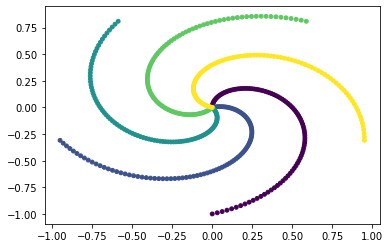

In [ ]:
x_test, y_test = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y_test = y_test.reshape(-1, 1)
print(x_test.shape, y_test.shape)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test.flatten(), s=15)

(500, 2) (500, 1)


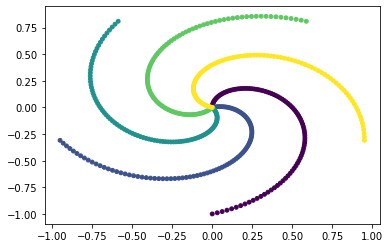

In [ ]:
x_treino, y_treino = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y_treino = y_treino.reshape(-1, 1)
print(x_treino.shape, y_treino.shape)

plt.scatter(x_treino[:, 0], x_treino[:, 1], c=y_treino.flatten(), s=15)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5591 - accuracy: 0.3760 - f1_m: 4.9800 - precision_m: 1247499904.0000 - recall_m: 2.4900
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4702 - accuracy: 0.4020 - f1_m: 4.9745 - precision_m: 1248749952.0000 - recall_m: 2.4873
Epoch 3/100
8/8 [==============================] - 0s 2m

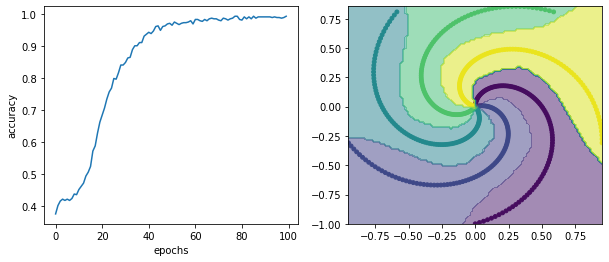

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test, y_test, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_test, y_test, model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_14 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5723 - accuracy: 0.3620 - f1_m: 4.9870 - precision_m: 1251249920.0000 - recall_m: 2.4935
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4810 - accuracy: 0.4140 - f1_m: 4.6551 - precision_m: 1166249984.0000 - recall_m: 2.3276
Epoch 3/100
8/8 [==============================] - 0s 2m

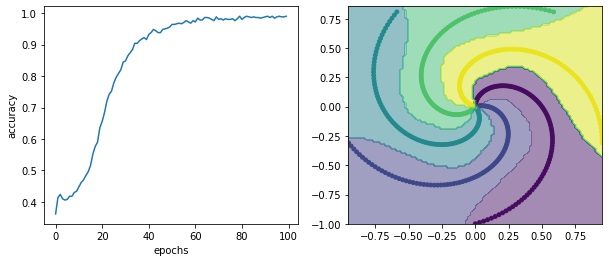

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_treino, y_treino, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_treino, y_treino, model)

* A acurácia obteve-se um valor de para teste de 0.93 e 0.99 para o valor de treino. 
* A precisão obteve um resultado de 0.82 de treino e 0.89 de teste.
* Recall apresentou resultados de 1.10 para teste e 1.07 para treino.
* F1-Score obteve resultados de 0.95 para teste e de 0.97 para treino.
* Em geral, todos valores estão próximos entre treino e teste. Nenhum deles apresentou overfitting.

### Make Classification - 4 Classes

(100, 2) (100, 1)


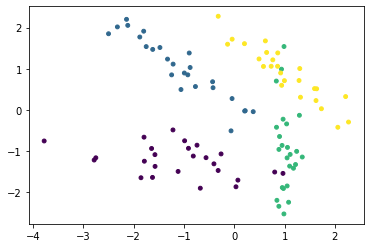

In [ ]:
x_test, y_test = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y_test = y_test.reshape(-1, 1)
print(x_test.shape, y_test.shape)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test.flatten(), s=15)

(100, 2) (100, 1)


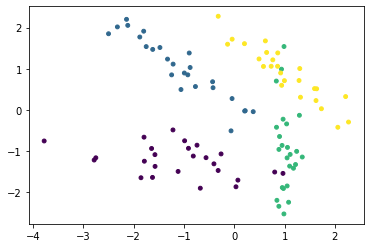

In [ ]:
x_treino, y_treino = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y_treino = y_treino.reshape(-1, 1)
print(x_treino.shape, y_treino.shape)

plt.scatter(x_treino[:, 0], x_treino[:, 1], c=y_treino.flatten(), s=15)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_17 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 1.5733 - accuracy: 0.3000 - f1_m: 2.5995 - precision_m: 480000000.0000 - recall_m: 1.2998
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4564 - accuracy: 0.6800 - f1_m: 2.1634 - precision_m: 410000000.0000 - recall_m: 1.0817
Epoch 3/100
2/2 [==============================] - 0s 2ms/

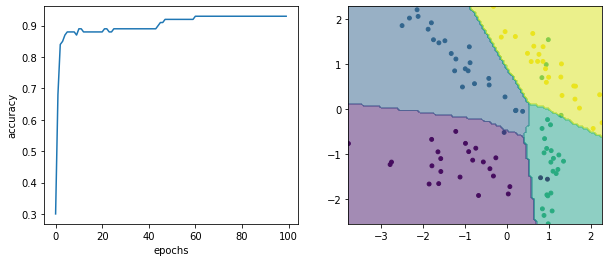

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test, y_test, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_test, y_test, model)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_20 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 1.6144 - accuracy: 0.0600 - f1_m: 3.5549 - precision_m: 610000000.0000 - recall_m: 1.7775
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4900 - accuracy: 0.8300 - f1_m: 3.5573 - precision_m: 615000000.0000 - recall_m: 1.7786
Epoch 3/100
2/2 [==============================] - 0s 2ms/

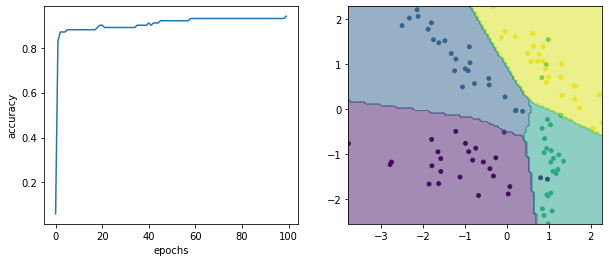

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_treino, y_treino, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_treino, y_treino, model)

* A acurácia obteve-se um valor de para teste de 0.93 e 0.94 para o valor de treino. 
* A precisão obteve um resultado de 0.82 de treino e 0.84 de teste.
* Recall apresentou resultados de 1.10 para teste e 1.10 para treino.
* F1-Score obteve resultados de 0.94 para teste e de 0.95 para treino.
* Em geral, todos valores estão próximos entre treino e teste. Nenhum deles apresentou overfitting. Até o momento esse foi o melhor resultado.

## **Retreinando os modelos**

### Regressão Logística

In [ ]:
logreg_C = [1e-4, 1e-3, 1e-2, 1e-1, 1]
best_c = logreg_C[0]
best_score = 0
best_accuracy = 0
avg_scores = []

for c in logreg_C:
    score = 0
    accuracy = 0
    for train_index, test_index in kfold.split(x_train_fold, y_train_fold):
        x_train_fold_two, x_test_fold_two = x_train_fold.iloc[train_index], x_train_fold.iloc[test_index]
        y_train_fold_two, y_test_fold_two = y_train_fold.iloc[train_index], y_train_fold.iloc[test_index]

        model = LogisticRegression(C=c, random_state=31, max_iter=2000)
        model.fit(x_train_fold_two, y_train_fold_two)
        pred = model.predict(x_test_fold_two)

        score += f1_score(y_test_fold_two, pred, average='micro')
        accuracy += accuracy_score(y_test_fold_two, pred)


    score = score / folds # média
    avg_scores.append(score)
    accuracy = accuracy / folds
    if (score > best_score):
        best_score = score
        best_accuracy = accuracy
        best_c = c

print(f'Melhor C: {best_c}. Resultou no F1 {best_score} e Acurácia {best_accuracy} durante o {folds}-fold')

Melhor C: 1. Resultou no F1 0.7273623013160891 e Acurácia 0.7273623013160891 durante o 10-fold


In [ ]:
model = LogisticRegression(C = best_c)
model.fit(x_train_fold_two, y_train_fold_two)
pred = model.predict(x_test_fold_two)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
f1 = f1_score(y_test_fold_two, pred, average='macro')
accuracy = accuracy_score(y_test_fold_two, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.769029813927543 e Acurácia 0.7690447400241838


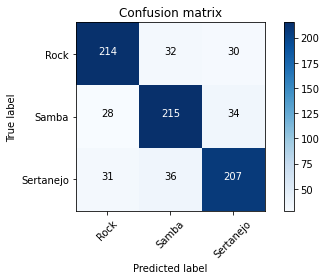

In [ ]:
conf = confusion_matrix(y_test_fold_two, pred)
plot_confusion_matrix(conf, ['Rock', 'Samba', 'Sertanejo'])

### Árvore de Decisão

Repetindo o mesmo procedimento para Árvore de decisão, mas agora utilizando GridSearch para simplificar o processo de cross validation:

In [ ]:
dtree = DecisionTreeClassifier()
dtree_params = { 'max_depth': [5, 10, 15], 'max_leaf_nodes': [10, 20, 30] }
grid = GridSearchCV(dtree, dtree_params, scoring='f1_macro', cv=folds)
grid.fit(x_train_fold_two, y_train_fold_two)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 15],
                         '

In [ ]:
print(f'Melhor depth: {grid.best_params_["max_depth"]}. Melhor num de folhas: {grid.best_params_["max_leaf_nodes"]}')
print(f'Resultou no F1 {grid.best_score_} durante o {folds}-fold')

Melhor depth: 10. Melhor num de folhas: 30
Resultou no F1 0.7320328617318881 durante o 10-fold


In [ ]:
pred = grid.predict(x_test_fold_two)
f1 = f1_score(y_test_fold_two, pred, average='macro')
accuracy = accuracy_score(y_test_fold_two, pred)
print(f'O melhor modelo resultou no F1 {f1} e Acurácia {accuracy}')

O melhor modelo resultou no F1 0.7532077721640572 e Acurácia 0.7533252720677146


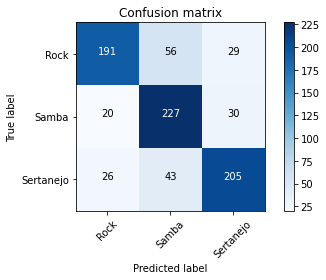

In [ ]:
conf = confusion_matrix(y_test_fold_two, pred)
plot_confusion_matrix(conf, ['Rock', 'Samba', 'Sertanejo'])

Agora, ao invés de termos nossas variáveis guardando o melhor valor de cada parâmetro, iremos recuperar esses valores do grid search e visualizar:

In [ ]:
grid_cv = pd.DataFrame.from_dict(grid.cv_results_)
grid_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041167,0.001432,0.002279,0.000401,5,10,"{'max_depth': 5, 'max_leaf_nodes': 10}",0.699717,0.702330,0.691112,0.736852,0.726843,0.724182,0.691821,0.728623,0.697320,0.710950,0.710975,0.015990,7
1,0.044822,0.001617,0.002160,0.000098,5,20,"{'max_depth': 5, 'max_leaf_nodes': 20}",0.716725,0.704003,0.701454,0.738087,0.727254,0.729301,0.713384,0.741338,0.714194,0.736550,0.722229,0.013542,5
2,0.046387,0.001238,0.002198,0.000078,5,30,"{'max_depth': 5, 'max_leaf_nodes': 30}",0.715371,0.706633,0.701348,0.736843,0.728699,0.729428,0.711949,0.741386,0.712920,0.736550,0.722113,0.013408,6
3,0.041889,0.000579,0.002062,0.000046,10,10,"{'max_depth': 10, 'max_leaf_nodes': 10}",0.699717,0.702330,0.691112,0.736852,0.726843,0.724182,0.691821,0.728623,0.697320,0.710950,0.710975,0.015990,7
4,0.052604,0.001374,0.002103,0.000099,10,20,"{'max_depth': 10, 'max_leaf_nodes': 20}",0.722256,0.714651,0.692399,0.742877,0.735489,0.737675,0.707869,0.722367,0.715307,0.741776,0.723267,0.015535,3


### 3 Clusters

(300, 2) (300, 1)


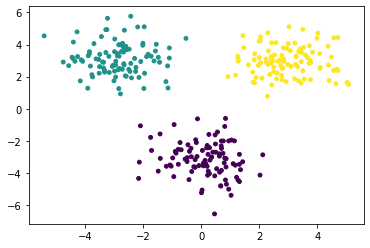

In [ ]:
x_test_two, y_test_two = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y_test_two = y_test_two.reshape(-1, 1)
print(x_test_two.shape, y_test_two.shape)

plt.scatter(x_test_two[:, 0], x_test_two[:, 1], c=y_test_two.flatten(), s=15)

(300, 2) (300, 1)


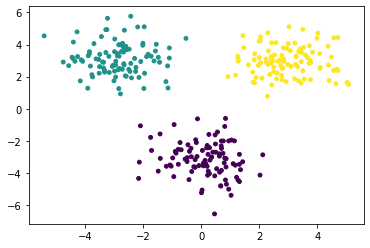

In [ ]:
x_treino_two, y_treino_two = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y_treino_two = y_treino_two.reshape(-1, 1)
print(x_treino_two.shape, y_treino_two.shape)

plt.scatter(x_treino_two[:, 0], x_treino_two[:, 1], c=y_treino_two.flatten(), s=15)

Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3961 - accuracy: 0.3400 - f1_m: 0.8670 - precision_m: 0.7741 - recall_m: 0.9933
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3578 - accuracy: 0.3433 - f1_m: 0.9967 - precision_m: 0.9275 - recall_m: 1.0999
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3244 - accuracy: 0.3433 - f1_m: 1.2527 - precision_m: 1.2479 - recall_m: 1.2725
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2976 - accuracy: 0.3433 - f1_m: 1.5100 - precision_m: 1.6956 - recall_m: 1.3995
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2752 - accuracy: 0.3400 - f1_m: 1.7419 - precision_m: 2.1083 - recall_m: 1.5286
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 1.2567 - accuracy: 0.3367 - f1_m: 1.9287 - precision_m: 2.3814 - recall_m: 1.6450
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - los

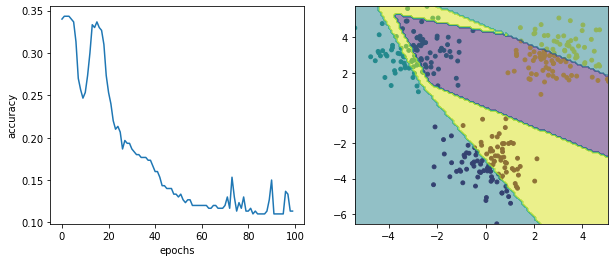

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=3, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test_two, y_test_two, batch_size=30, epochs=100)

plot_hist_and_predictions(hist.history, x_test_two, y_test_two, model)

Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 1.4851 - accuracy: 0.3833 - f1_m: 1.3577 - precision_m: 1.4926 - recall_m: 1.2536
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 1.4491 - accuracy: 0.3933 - f1_m: 1.3231 - precision_m: 1.5376 - recall_m: 1.1754
Epoch 3/100
10/10 [==============================] - 0s 1ms/step - loss: 1.4174 - accuracy: 0.4100 - f1_m: 1.2574 - precision_m: 1.6145 - recall_m: 1.0440
Epoch 4/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3863 - accuracy: 0.4200 - f1_m: 1.2507 - precision_m: 1.6891 - recall_m: 1.0080
Epoch 5/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3582 - accuracy: 0.4400 - f1_m: 1.2459 - precision_m: 1.7368 - recall_m: 0.9938
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 1.3316 - accuracy: 0.4600 - f1_m: 1.2401 - precision_m: 1.7397 - recall_m: 0.9740
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - los

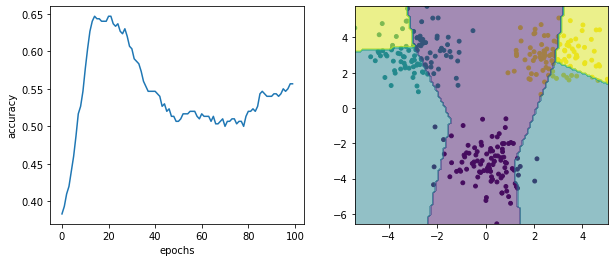

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=3, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=3, activation="softmax")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_treino_two, y_treino_two, batch_size=30, epochs=100)

plot_hist_and_predictions(hist.history, x_treino_two, y_treino_two, model)

* A acurácia se refere à proximidade entre o valor obtido de treino e o valor de teste. Como resultado, obteve-se um valor de para teste de 0.07 e 0.28 para o valor de treino. 
* A precisão é o grau de variação de resultados de uma amostra, tendo como base o desvio-padrão. Obtivemos um resultado de 3.88 para treino e 0.69 de teste.
* Recall é a frequência em que o seu classificador encontra os exemplos de uma classe, ou seja, o numero de verdadeiros positivos e verdadeiros negativos. Os resultados de recall froma de 2.21 para teste e 0.80 para treino.
* F1-Score faz uma combinação entre precisão e recall, em relação ao quanto o classificador atinge resultados verdadeiros e o quanto a variabilidade dos ddos é pequena, tornando o modelo mais confiável. Como resultados, obtivemos os valores de 2.8 para teste e de 0.73 para treino.
* Em geral, os resultados obtidos de reteste são proximos a do modelo de teste.

### 4 Clusters

(400, 2) (400, 1)


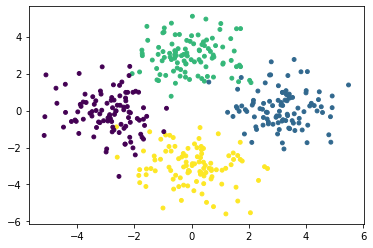

In [ ]:
x_test_two, y_test_two = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y_test_two = y_test_two.reshape(-1, 1)
print(x_test_two.shape, y_test_two.shape)

plt.scatter(x_test_two[:, 0], x_test_two[:, 1], c=y_test_two.flatten(), s=15)

(400, 2) (400, 1)


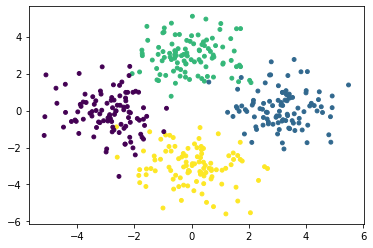

In [ ]:
x_treino_two, y_treino_two = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y_treino_two = y_treino_two.reshape(-1, 1)
print(x_treino_two.shape, y_treino_two.shape)

plt.scatter(x_treino_two[:, 0], x_treino_two[:, 1], c=y_treino_two.flatten(), s=15)

Epoch 1/100
13/13 [==============================] - 0s 1ms/step - loss: 1.2900 - accuracy: 0.3100 - f1_m: 3.7211 - precision_m: 155384640.0000 - recall_m: 1.9558
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 1.1787 - accuracy: 0.4975 - f1_m: 2.9717 - precision_m: 9.9509 - recall_m: 1.7876
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 1.0705 - accuracy: 0.6250 - f1_m: 2.7507 - precision_m: 7.3675 - recall_m: 1.7291
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 0.9648 - accuracy: 0.6725 - f1_m: 2.5973 - precision_m: 5.7435 - recall_m: 1.7187
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8699 - accuracy: 0.7775 - f1_m: 2.4304 - precision_m: 3.7995 - recall_m: 1.8062
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 0.7801 - accuracy: 0.8275 - f1_m: 2.2652 - precision_m: 3.1921 - recall_m: 1.7827
Epoch 7/100
13/13 [==============================] - 0s 1ms/st

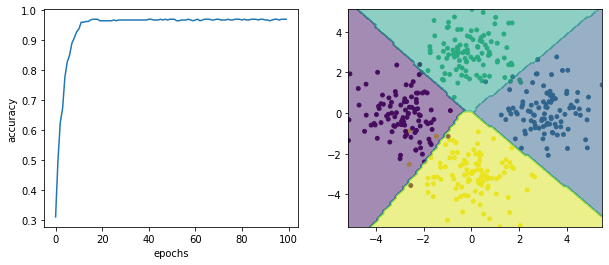

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=20, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=4, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test_two, y_test_two, batch_size=32, epochs=100)

plot_hist_and_predictions(hist.history, x_test_two, y_test_two, model)

Epoch 1/100
13/13 [==============================] - 0s 1ms/step - loss: 1.3778 - accuracy: 0.4000 - f1_m: 3.6392 - precision_m: 307692288.0000 - recall_m: 1.9234
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 1.2229 - accuracy: 0.4800 - f1_m: 3.1794 - precision_m: 10.1004 - recall_m: 1.9690
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 1.0987 - accuracy: 0.4900 - f1_m: 2.6990 - precision_m: 5.9417 - recall_m: 1.8215
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 0.9954 - accuracy: 0.5600 - f1_m: 2.2385 - precision_m: 3.6012 - recall_m: 1.6553
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 0.9074 - accuracy: 0.6125 - f1_m: 1.7878 - precision_m: 2.5272 - recall_m: 1.4021
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 0.8316 - accuracy: 0.6700 - f1_m: 1.5410 - precision_m: 2.0743 - recall_m: 1.2453
Epoch 7/100
13/13 [==============================] - 0s 2ms/s

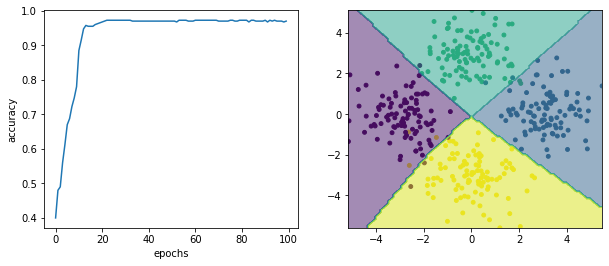

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=20, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=4, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_treino_two, y_treino_two, batch_size=32, epochs=100)

plot_hist_and_predictions(hist.history, x_treino_two, y_treino_two, model)

* A acurácia obteve-se um valor de para teste de 0.91 e 0.96 para o valor de treino. 
* A precisão obteve um resultado de 0.97 de treino e 0.78 de teste.
* Recall apresentou resultados de 1.19 para teste e 1.03 para treino.
* F1-Score obteve resultados de 1.06 para teste e de 0.89 para treino.
* Em geral, os resultados obtidos de reteste são proximos a do modelo de teste.

### Espiral - 5 Classes

(100, 2) (500, 1)


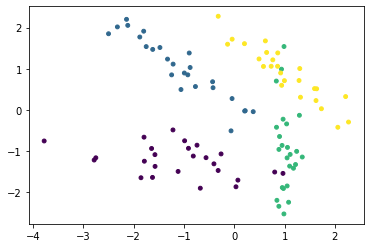

In [ ]:
x_test_two, y_test_two = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y_test_two = y_test_two.reshape(-1, 1)
print(x_test.shape, y_test_two.shape)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test.flatten(), s=15)

(100, 2) (500, 1)


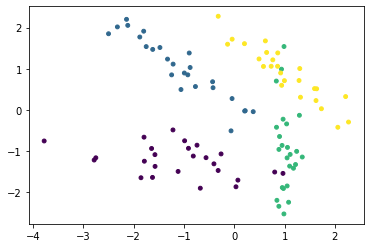

In [ ]:
x_treino_two, y_treino_two = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y_treino_two = y_treino_two.reshape(-1, 1)
print(x_treino.shape, y_treino_two.shape)

plt.scatter(x_treino[:, 0], x_treino[:, 1], c=y_treino.flatten(), s=15)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_33 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5807 - accuracy: 0.3140 - f1_m: 4.9962 - precision_m: 1247499904.0000 - recall_m: 2.4981
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4971 - accuracy: 0.4020 - f1_m: 5.0032 - precision_m: 1250000128.0000 - recall_m: 2.5016
Epoch 3/100
8/8 [==============================] - 0s 2

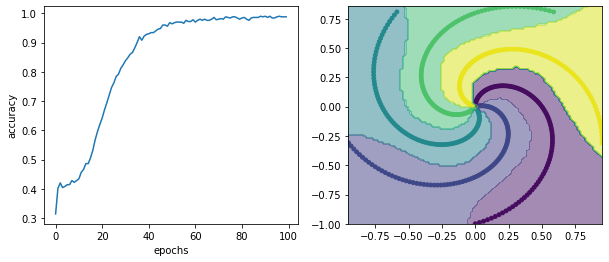

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test_two, y_test_two, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_test_two, y_test_two, model)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_36 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 2ms/step - loss: 1.5560 - accuracy: 0.3040 - f1_m: 4.9988 - precision_m: 1249999872.0000 - recall_m: 2.4994
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 1.4648 - accuracy: 0.3980 - f1_m: 4.8402 - precision_m: 1217499904.0000 - recall_m: 2.4201
Epoch 3/100
8/8 [==============================] - 0s 2

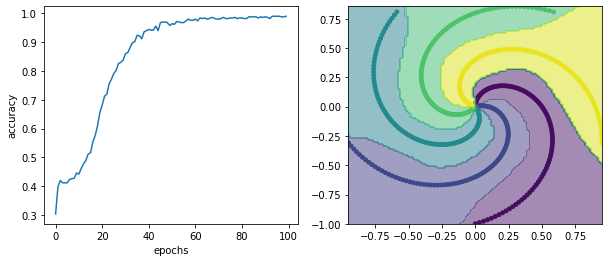

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_treino_two, y_treino_two, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_treino_two, y_treino_two, model)

* A acurácia obteve-se um valor de para teste de 0.94 e 0.98 para o valor de treino. 
* A precisão obteve um resultado de 0.82 de treino e 0.89 de teste.
* Recall apresentou resultados de 1.12 para teste e 1.07 para treino.
* F1-Score obteve resultados de 0.94 para teste e de 0.97 para treino.
* Em geral, os resultados obtidos de reteste são proximos a do modelo de teste.

### Make Classification - 4 Classes

(100, 2) (100, 1)


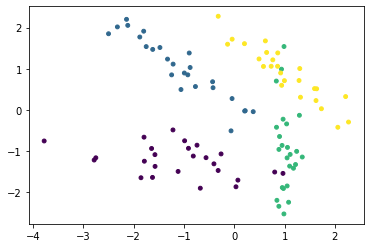

In [ ]:
x_test_two, y_test_two = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y_test_two = y_test_two.reshape(-1, 1)
print(x_test_two.shape, y_test_two.shape)

plt.scatter(x_test_two[:, 0], x_test_two[:, 1], c=y_test_two.flatten(), s=15)

(100, 2) (100, 1)


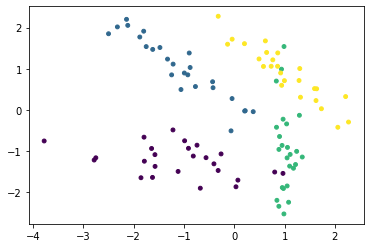

In [ ]:
x_treino_two, y_treino_two = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y_treino_two = y_treino_two.reshape(-1, 1)
print(x_treino_two.shape, y_treino_two.shape)

plt.scatter(x_treino_two[:, 0], x_treino_two[:, 1], c=y_treino_two.flatten(), s=15)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_39 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 1.6912 - accuracy: 0.2200 - f1_m: 3.5365 - precision_m: 675000000.0000 - recall_m: 1.7682
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 1.5414 - accuracy: 0.2500 - f1_m: 3.3388 - precision_m: 595000000.0000 - recall_m: 1.6694
Epoch 3/100
2/2 [==============================] - 0s 2ms

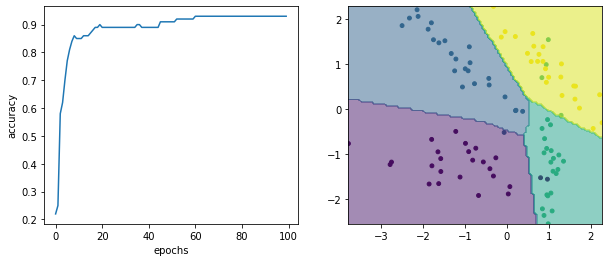

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_test_two, y_test_two, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_test_two, y_test_two, model)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_42 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 505       
Total params: 21,205
Trainable params: 21,205
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 1.5615 - accuracy: 0.4600 - f1_m: 3.4536 - precision_m: 625000000.0000 - recall_m: 1.7268
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 1.4412 - accuracy: 0.7400 - f1_m: 3.3100 - precision_m: 665000000.0000 - recall_m: 1.6550
Epoch 3/100
2/2 [==============================] - 0s 2ms

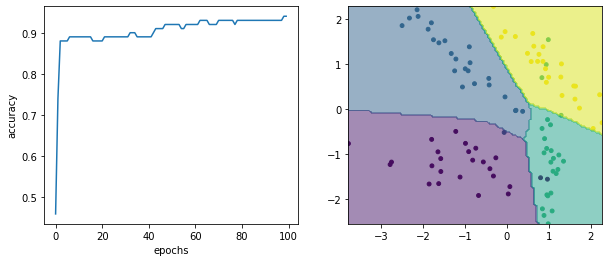

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=200, activation="relu", input_dim=2),
    tf.keras.layers.Dense(units=100, activation="relu"),
    tf.keras.layers.Dense(units=5, activation="softmax")
])
model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy',f1_m, precision_m, recall_m])

hist = model.fit(x_treino_two, y_treino_two, batch_size=64, epochs=100)

plot_hist_and_predictions(hist.history, x_treino_two, y_treino_two, model)

* A acurácia obteve-se um valor de para teste de 0.93 e 0.94 para o valor de treino. 
* A precisão obteve um resultado de 0.83 de treino e 0.83 de teste.
* Recall apresentou resultados de 1.13 para teste e 1.12 para treino.
* F1-Score obteve resultados de 0.95 para teste e de 0.95 para treino.
* Em geral, os resultados obtidos de reteste são proximos a do modelo de teste. Porem, mesmo sendo muito próximos, os resultados do reteste são mais precisos.